This notebooks aims to replicate the experiment from Section 4.3 of the paper "[What can linearized neural networks actually say about generalization?](https://arxiv.org/abs/2106.06770)" on comparing the performance of linearized networks at initialization vs non-linear networks vs linearized networks after non-linear pretraining.

In [1]:
!pip install -U -q "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
!pip install -U -q flax neural-tangents chex

In [3]:
import flax.linen as nn
from flax.core.frozen_dict import freeze
from flax.serialization import to_state_dict, from_state_dict
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import optax
import chex
import neural_tangents as nt
from scipy.sparse.linalg import eigsh
import numpy as np
import copy
import sys

In [4]:
class Lenet300_100(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.relu(nn.Dense(300)(x))
        x = nn.relu(nn.Dense(100)(x))
        x = nn.Dense(1)(x)
        return x

In [5]:
key = jax.random.PRNGKey(100)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_dir = "/content/drive/MyDrive/Paper Implementations/What can linearized neural networks actually say about generalization?/artifacts_mnist_mlp"

In [8]:
# !unzip "/content/artifacts_mnist_mlp-20230104T024738Z-001.zip"

In [9]:
data_dir = "/content/artifacts_mnist_mlp"

In [10]:
LABEL_IDX = 30
VERBOSE = True

In [11]:
data = jnp.load(f'{data_dir}/data.npy', allow_pickle=True)
eig_vecs_init = jnp.load(f'{data_dir}/eig_vecs_init.npy', allow_pickle=True)
print(data.shape, eig_vecs_init.shape)

(20000, 28, 28, 1) (100, 20000)


In [12]:
def binarize_eigenfunctions(eigen_vec):
    return ((jnp.sign(eigen_vec) + 1) // 2).astype(jnp.float32)

In [13]:
def get_data(data, eigvecs, label_idx):
    train_ds = {
        "data": data[:18000],
        "labels": binarize_eigenfunctions(eig_vecs_init[label_idx, :18000]),
    }

    test_ds = {
        "data": data[18000:],
        "labels": binarize_eigenfunctions(eig_vecs_init[label_idx, 18000:]),
    }

    return train_ds, test_ds

In [14]:
model = Lenet300_100()
variables_state_dict = jnp.load(f'{data_dir}/variables_init.npy', allow_pickle=True)[()]
batch = jnp.ones([1, 28, 28, 1])
init_variables = model.init(key, batch)
load_variables = from_state_dict(init_variables, variables_state_dict)

In [15]:
def get_apply_fn(model, variables, bn=False, train=False):
    if not bn:
        model_state, _ = variables.pop("params")

        def apply_fn(params, x):
            new_vars = freeze({'params': params, **model_state})
            logits = model.apply(new_vars, x, mutable=False)
            return logits
    else:
        def apply_fn(params, x):
            logits = model.apply(params, x, mutable=train)
            return logits

    return apply_fn

In [16]:
def get_new_apply_fn(model, load_variables, linearize_flag=False, biased_flag=False):
    if linearize_flag:
        if biased_flag is False:
            model_state, params = load_variables.pop("params")
            original_apply_fn = get_apply_fn(model, load_variables, bn=False, train=False)
            new_apply_fn = nt.linearize(original_apply_fn, params)
            def linear_apply_fn(variables, x, train=True, mutable=False):
                if not mutable:
                    return new_apply_fn(variables["params"], x) - original_apply_fn(params, x)
                else:
                    model_state, params_new = variables.pop("params")
                    return (new_apply_fn(params_new, x) - original_apply_fn(params, x)), model_state
            apply_fn = linear_apply_fn
        else:
            model_state, params = load_variables.pop("params")
            original_apply_fn = get_apply_fn(model, load_variables, bn=False, train=False)
            new_apply_fn = nt.linearize(original_apply_fn, params)
            def linear_apply_fn(variables, x, train=True, mutable=False):
                if not train or not mutable:
                    return new_apply_fn(variables["params"], x)
                else:
                    model_state, params = variables.pop("params")
                    return new_apply_fn(params, x), model_state
            apply_fn = linear_apply_fn
    else:
        apply_fn = model.apply

    return apply_fn

In [17]:
def create_learning_rate_fn(base_learning_rate, steps_per_epoch, num_epochs, lr_schedule="cyclic"):
    if lr_schedule == "linear":

        schedule_fn = optax.linear_schedule(
            init_value=base_learning_rate,
            end_value=0,
            transition_steps=num_epochs * steps_per_epoch,
        )

    elif lr_schedule == "fixed":

        schedule_fn = optax.constant_schedule(value=base_learning_rate)

    elif lr_schedule == "piecewise":
        raise NotImplementedError()

    elif lr_schedule == "cyclic":

        schedule_fn = optax.linear_onecycle_schedule(
            peak_value=base_learning_rate,
            transition_steps=num_epochs * steps_per_epoch,
            pct_start=0.4,
            pct_final=1,
            div_factor=1e8,
            final_div_factor=1e8,
        )

    else:
        raise ValueError("Learning rate error not specified")

    return schedule_fn

@chex.dataclass
class TrainState:
    step: int
    opt_state: optax.OptState
    target: chex.ArrayTree
    model_state: chex.ArrayTree

def create_train_state(
    init_variables,
    optimizer_type,
    learning_rate_fn,
    momentum=None,
):
    """Create initial training state."""
    model_state, params = init_variables.pop("params")
    transforms = []

    if optimizer_type == "sgd":
        transforms += [optax.sgd(learning_rate=learning_rate_fn, momentum=momentum)]
    elif optimizer_type == "adam":
        transforms += [optax.adam(learning_rate=learning_rate_fn)]
    else:
        raise ValueError("Optimizer type not accepted.")

    optimizer = optax.chain(*transforms)
    opt_state = optimizer.init(params)

    state = TrainState(step=0, opt_state=opt_state, target=params, model_state=model_state)
    return state, optimizer

def generate_binary_cross_entropy_loss_fn(apply_fn, state, batch):
    def loss_fn(params):
        variables = make_variables(params, state.model_state)
        logits, new_model_state = apply_fn(variables, batch["data"], mutable=["batch_stats"])
        loss = binary_cross_entropy_loss_with_logits(logits, batch["labels"])
        return loss, (new_model_state, logits)

    return loss_fn

def print_progress(epoch, test_summary, train_summary):
    print(
        "Epoch: %d, train loss: %.4f, train acc.: %.2f%%, test acc.: %.2f%%"
        % (
            epoch,
            train_summary["loss"],
            train_summary["accuracy"] * 100,
            test_summary["accuracy"] * 100,
        )
    )

def split_batch_indices(batch_size, rng, ds):
    ds_size = len(ds["data"])
    if batch_size > 0:
        steps_per_epoch = ds_size // batch_size
    else:
        steps_per_epoch = 1

    if rng is not None:
        indices = jax.random.permutation(rng, ds_size)
    else:
        indices = jnp.arange(ds_size)

    if batch_size > 0:
        indices = indices[: steps_per_epoch * batch_size]  # skip incomplete batch
    indices = indices.reshape((steps_per_epoch, batch_size))
    return indices, steps_per_epoch

def weight_norm(params):
    theta, _ = ravel_pytree(params)
    return jnp.linalg.norm(theta)

def make_variables(params, model_state):
    return freeze({"params": params, **model_state})

def binary_cross_entropy_loss_with_logits(logits, labels):
    return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, labels[:, jnp.newaxis]))

def compute_binary_accuracy_metrics(logits, labels):
    loss = binary_cross_entropy_loss_with_logits(logits, labels)
    predictions = ((jnp.sign(logits) + 1) // 2).astype(float)
    labels_bin = (labels[:, jnp.newaxis] > 0.5).astype(float)
    accuracy = 1 - jnp.abs(predictions - labels_bin).mean()
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

def create_train_step_fn(
    apply_fn,
    optimizer,
):
    @jax.jit
    def train_step_fn(state, batch, rng_key):

        loss_fn = generate_binary_cross_entropy_loss_fn(apply_fn, state, batch)

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        aux, grad = grad_fn(state.target)

        new_model_state, logits = aux[1]
        # jax.debug.print(str(len(new_model_state)))
        updates, new_opt_state = optimizer.update(grad, state.opt_state, params=state.target)
        new_target = optax.apply_updates(state.target, updates)

        metrics = compute_binary_accuracy_metrics(logits, batch["labels"])

        metrics["loss_grad_norm"] = jax.device_get(weight_norm(grad))
        metrics["weight_norm"] = jax.device_get(weight_norm(new_target))

        new_state = state.replace(
            step=state.step + 1,
            model_state=new_model_state,
            opt_state=new_opt_state,
            target=new_target,
        )
        return new_state, metrics

    return train_step_fn


def create_eval_model_fn(apply_fn):
    @jax.jit
    def eval_step_fn(state, batch):

        params = state.target
        variables = make_variables(params, state.model_state)
        logits = apply_fn(variables, batch["data"], mutable=False)

        metrics = compute_binary_accuracy_metrics(logits, batch["labels"])

        return metrics

    def eval_model_fn(state, test_ds, batch_size=-1):
        indices, _ = split_batch_indices(batch_size, None, test_ds)
        batch_metrics = []
        for _, perm in enumerate(indices):
            batch = {k: v[perm] for k, v in test_ds.items()}
            metrics = eval_step_fn(state, batch)
            batch_metrics.append(jax.device_get(metrics))

        metrics_np = {
            k: np.mean([metrics[k] for metrics in batch_metrics]) for k in batch_metrics[0]
        }

        return metrics_np

    return eval_model_fn


def sgd_train(
    train_ds,
    test_ds,
    epochs,
    max_lr,
    batch_size,
    lr_schedule,
    momentum,
    apply_fn,
    init_variables,
    key,
    optimizer="sgd",
):
    if VERBOSE:
        print("Initializing optimizer...")

    learning_rate_fn = create_learning_rate_fn(
        base_learning_rate=max_lr,
        num_epochs=epochs,
        steps_per_epoch=len(train_ds["labels"]) // batch_size,
        lr_schedule=lr_schedule,
    )

    init_state, optimizer = create_train_state(
        optimizer_type=optimizer,
        momentum=momentum,
        init_variables=init_variables,
        learning_rate_fn=learning_rate_fn,
    )
    state = copy.deepcopy(init_state)

    train_step_fn = create_train_step_fn(
        apply_fn=apply_fn,
        optimizer=optimizer,
    )
    eval_model_fn = create_eval_model_fn(
        apply_fn=apply_fn,
    )

    if VERBOSE:
        print("Starting training...")
    rng = jax.random.split(key, epochs)

    for epoch in range(epochs):
        perms, steps_per_epoch = split_batch_indices(batch_size, rng[epoch], train_ds)
        for step, perm in enumerate(perms):
            batch = {k: v[perm] for k, v in train_ds.items()}

            state, metrics = train_step_fn(
                state=state, batch=batch, rng_key=jax.random.fold_in(rng[epoch], step)
            )

        if epoch == 0:
            train_stats = jax.tree_util.tree_map(lambda m: jnp.array([m]), metrics)
        else:
            train_stats = jax.tree_util.tree_map(lambda o, m: jnp.concatenate((o, jnp.array([m]))), train_stats, metrics)

        train_summary = jax.tree_util.tree_map(lambda x: jax.device_get(x.mean()), metrics)
        test_summary = eval_model_fn(state, test_ds, batch_size)

        if VERBOSE:
            print_progress(epoch, test_summary, train_summary)

    train_stats = jax.tree_util.tree_map(lambda x: jax.device_get(x), train_stats)
    output_summary = {
        "train": train_summary,
        "test": test_summary,
        "train_stats": train_stats,
        "init_state": init_state,
        "end_state": state,
    }

    return output_summary

In [18]:
key, new_key = jax.random.split(key)

In [19]:
train_ds, test_ds = get_data(data, eig_vecs_init, LABEL_IDX)

In [20]:
apply_fn = get_new_apply_fn(model, load_variables, linearize_flag=False, biased_flag=False)
nn_summary = sgd_train(
        train_ds=train_ds,
        test_ds=test_ds,
        apply_fn=apply_fn,
        init_variables=load_variables,
        key=key,
        epochs=50,
        max_lr=0.05,
        lr_schedule="linear",
        momentum=0.9,
        batch_size=128,
        optimizer="sgd"
    )

Initializing optimizer...
Starting training...
Epoch: 0, train loss: 0.2860, train acc.: 88.28%, test acc.: 83.80%
Epoch: 1, train loss: 0.4424, train acc.: 76.56%, test acc.: 82.29%
Epoch: 2, train loss: 0.3331, train acc.: 86.72%, test acc.: 85.78%
Epoch: 3, train loss: 0.2360, train acc.: 89.06%, test acc.: 84.22%
Epoch: 4, train loss: 0.2762, train acc.: 85.16%, test acc.: 84.84%
Epoch: 5, train loss: 0.1923, train acc.: 91.41%, test acc.: 85.36%
Epoch: 6, train loss: 0.2493, train acc.: 89.84%, test acc.: 84.79%
Epoch: 7, train loss: 0.2165, train acc.: 91.41%, test acc.: 84.69%
Epoch: 8, train loss: 0.2187, train acc.: 92.97%, test acc.: 85.00%
Epoch: 9, train loss: 0.1524, train acc.: 96.09%, test acc.: 85.36%
Epoch: 10, train loss: 0.1449, train acc.: 92.97%, test acc.: 84.43%
Epoch: 11, train loss: 0.2243, train acc.: 89.84%, test acc.: 84.74%
Epoch: 12, train loss: 0.2102, train acc.: 91.41%, test acc.: 83.44%
Epoch: 13, train loss: 0.1090, train acc.: 95.31%, test acc.: 84.0

In [21]:
apply_fn = get_new_apply_fn(model, load_variables, linearize_flag=True, biased_flag=True)
ntk_init_summary = sgd_train(
        train_ds=train_ds,
        test_ds=test_ds,
        apply_fn=apply_fn,
        init_variables=load_variables,
        key=key,
        epochs=50,
        max_lr=0.05,
        lr_schedule="linear",
        momentum=0.9,
        batch_size=128,
        optimizer="sgd"
    )

Initializing optimizer...
Starting training...
Epoch: 0, train loss: 0.1357, train acc.: 98.44%, test acc.: 97.86%
Epoch: 1, train loss: 0.1186, train acc.: 97.66%, test acc.: 97.71%
Epoch: 2, train loss: 0.0934, train acc.: 99.22%, test acc.: 97.76%
Epoch: 3, train loss: 0.0456, train acc.: 100.00%, test acc.: 98.02%
Epoch: 4, train loss: 0.0725, train acc.: 100.00%, test acc.: 98.39%
Epoch: 5, train loss: 0.0572, train acc.: 100.00%, test acc.: 97.29%
Epoch: 6, train loss: 0.0490, train acc.: 99.22%, test acc.: 98.44%
Epoch: 7, train loss: 0.0474, train acc.: 100.00%, test acc.: 98.07%
Epoch: 8, train loss: 0.0698, train acc.: 99.22%, test acc.: 98.18%
Epoch: 9, train loss: 0.0463, train acc.: 99.22%, test acc.: 98.18%
Epoch: 10, train loss: 0.0280, train acc.: 100.00%, test acc.: 97.92%
Epoch: 11, train loss: 0.0430, train acc.: 100.00%, test acc.: 98.28%
Epoch: 12, train loss: 0.0287, train acc.: 100.00%, test acc.: 98.18%
Epoch: 13, train loss: 0.0366, train acc.: 100.00%, test ac

In [22]:
init_model_state, _ = load_variables.pop("params")  # We reinitalize batch norm to not introduce an unfair advantage
pretrained_variables = make_variables(nn_summary["end_state"].target, init_model_state)
apply_fn = get_new_apply_fn(model, pretrained_variables, linearize_flag=True, biased_flag=False)

ntk_pretrained_summary = sgd_train(
        train_ds=train_ds,
        test_ds=test_ds,
        apply_fn=apply_fn,
        init_variables=pretrained_variables,
        key=key,
        epochs=50,
        max_lr=0.05,
        lr_schedule="linear",
        momentum=0.9,
        batch_size=128,
        optimizer="sgd"
    )

Initializing optimizer...
Starting training...
Epoch: 0, train loss: 0.4642, train acc.: 98.44%, test acc.: 84.38%
Epoch: 1, train loss: 0.2407, train acc.: 98.44%, test acc.: 84.90%
Epoch: 2, train loss: 0.0000, train acc.: 100.00%, test acc.: 84.90%
Epoch: 3, train loss: 0.0685, train acc.: 99.22%, test acc.: 84.95%
Epoch: 4, train loss: 0.3456, train acc.: 98.44%, test acc.: 84.58%
Epoch: 5, train loss: 0.0000, train acc.: 100.00%, test acc.: 84.95%
Epoch: 6, train loss: 0.0044, train acc.: 100.00%, test acc.: 85.05%
Epoch: 7, train loss: 0.1086, train acc.: 99.22%, test acc.: 84.58%
Epoch: 8, train loss: 0.0000, train acc.: 100.00%, test acc.: 85.10%
Epoch: 9, train loss: 0.0000, train acc.: 100.00%, test acc.: 84.69%
Epoch: 10, train loss: 0.0000, train acc.: 100.00%, test acc.: 84.90%
Epoch: 11, train loss: 0.0000, train acc.: 100.00%, test acc.: 84.84%
Epoch: 12, train loss: 0.0000, train acc.: 100.00%, test acc.: 84.69%
Epoch: 13, train loss: 0.0000, train acc.: 100.00%, test a

In [23]:
train_loss_nn = nn_summary['train_stats']['loss']
train_loss_ntk_init = ntk_init_summary['train_stats']['loss']
train_loss_ntk_pretrained = ntk_pretrained_summary['train_stats']['loss']

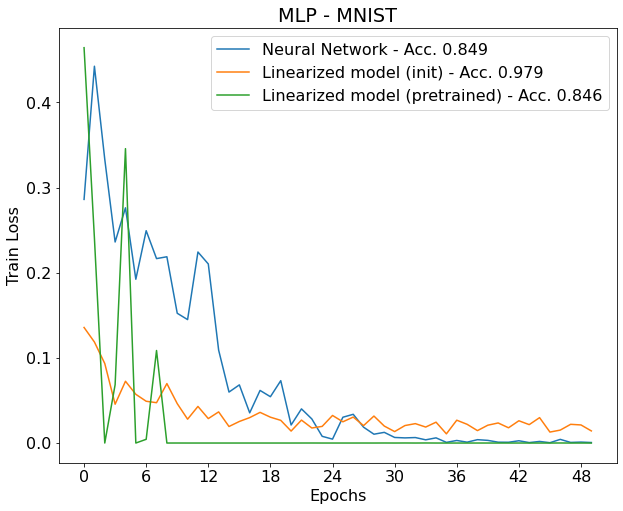

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["font.size"] = 16

tot = train_loss_nn.shape[0]
fig0, ax0 = plt.subplots(1, 1)
ax0.plot(range(tot), train_loss_nn, label='Neural Network' + f" - Acc. {nn_summary['test']['accuracy']:.3f}")
ax0.plot(range(tot), train_loss_ntk_init, label='Linearized model (init)' + f" - Acc. {ntk_init_summary['test']['accuracy']:.3f}")
ax0.plot(range(tot), train_loss_ntk_pretrained, label='Linearized model (pretrained)' + f" - Acc. {ntk_pretrained_summary['test']['accuracy']:.3f}")
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Train Loss')
ax0.set_title('MLP - MNIST')
ax0.legend();